# Load reviews and import modules

In [1]:
import numpy as np
import pandas as pd

In [2]:
with open('../datasets/imdb_reviews.pcl2', 'rb') as pcl_file:
    import pickle
    dataset = pickle.load(pcl_file)

---

# Bag Of Words

## Vectorize the reviews

Whole dataset contains `N` distinct words, so each review turns into a vector with `N` components, in which each coordinate represents the number of occurences of corresponding word in the review.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

reviews = dataset['review'].map(lambda r: ' '.join([' '.join(s) for s in r]))

vectorizer = CountVectorizer(ngram_range=(1,1))
review_codes = vectorizer.fit_transform(reviews.values)

## Calculate co-occurence matrix

The number of times two particular words occur in the same review can be calculated via multiplying transposed matrix of review codes and itself. 

In [4]:
# coo_matrix = review_codes.T * review_codes

## Find the most frequent words (of length more than 3) and their codes

In [5]:
from keras.utils import np_utils

nbs_occur = np.asarray(review_codes.sum(axis=0)).ravel()
feat_names = vectorizer.get_feature_names()

nb_top = 20
sz = review_codes.shape[1]

pairs = [x for x in zip(nbs_occur, feat_names) if len(x[1]) > 3]
top_pairs = sorted(pairs, reverse=True)[:nb_top]
top_words = [x[1] for x in top_pairs]
top_word_codes = np_utils.to_categorical([vectorizer.vocabulary_.get(x) for x in top_words], nb_classes=sz)

Using Theano backend.


## Use SVD and transform 20 most frequent words into 2D vectors

In [6]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD()
svd.fit(review_codes)
top_svd = svd.transform(top_word_codes)

## Visualize 20 most frequent words as 2D points

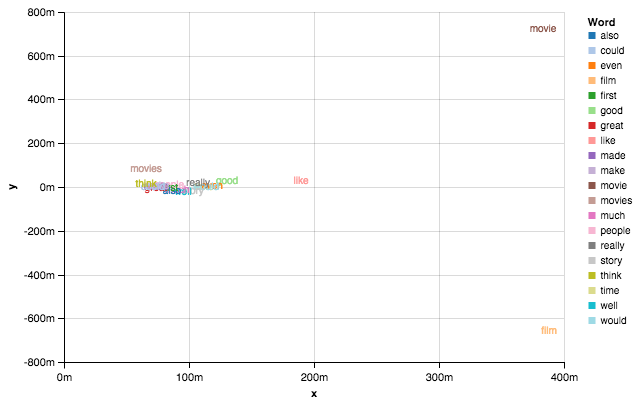

In [7]:
from altair import *

svd_tidy = pd.DataFrame(top_svd, columns=['x', 'y'])
svd_tidy['word'] = top_words

Chart(svd_tidy).mark_text().encode(
    x='x',
    y='y',
    color=Color('word', title='Word', scale=Scale(range='category20')),
    text='word'
)

---

# Word2vec

## Reorganize the data

In [8]:
sentences = []
for r in dataset['review']:
    sentences += r

## Train the model

In [9]:
from gensim.models import word2vec

nb_features = 100
nb_workers = 4

w2v_model = word2vec.Word2Vec(sentences, workers=nb_workers, size=nb_features)

In [10]:
w2v_model.init_sims(replace=True)

## Reduce dimensionality with TSNE

Use only 20 words to fit TSNE model, because otherwise MemoryError occurs.

In [11]:
from sklearn.manifold import TSNE

# svd_assist = TruncatedSVD(n_components=5)
# lower_dim = svd_assist.fit_transform(w2v_model.syn0)

tsne_model = TSNE()
top_tsne = tsne_model.fit_transform(np.array([w2v_model[w] for w in top_words]))

## Visualize 20 most frequent words as 2D points

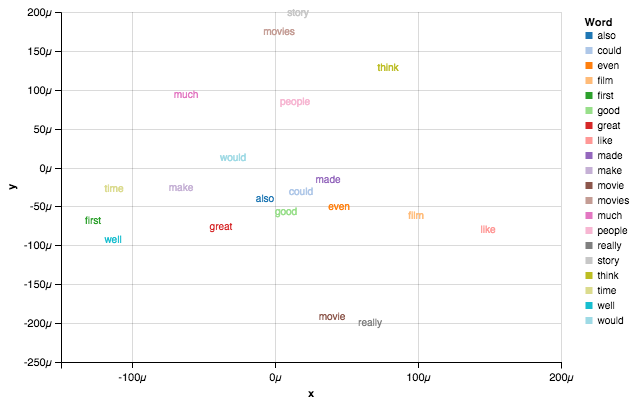

In [12]:
from altair import *

tsne_tidy = pd.DataFrame(top_tsne, columns=['x', 'y'])
tsne_tidy['word'] = top_words

Chart(tsne_tidy).mark_text().encode(
    x='x',
    y='y',
    color=Color('word', title='Word', scale=Scale(range='category20')),
    text='word'
)

# Models

## Prepare the data

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test = train_test_split(dataset, train_size=20000, stratify=dataset['rating'])

In [15]:
x_valid, x_test = train_test_split(x_test, train_size=2500, stratify=x_test['rating'])

In [16]:
xs = [x_train, x_valid, x_test]

In [17]:
y_train, y_valid, y_test = [x['sentiment'] for x in xs]

In [18]:
x_train, x_valid, x_test = [x.drop('sentiment', axis=1) for x in xs]

---

# Model 1 (using per word sentiment)

## Divide review codes according to partition 

In [19]:
review_codes_train, review_codes_valid, review_codes_test = [review_codes[x.index.values] for x in xs]

## Build and train the model

First, turn negative reviews into actual negative rows. Then, sum all those rows. The resulting vector indicates which words are positive and which are negative. Knowing this turn negative words into actual negative columns and sum all the columns. The resulting vector indicates which reviews are considered to be positive and which -- negative.

In [20]:
from scipy.sparse import diags

signed_review_codes_train = diags([y_train * 2 - 1], [0]) * review_codes_train

word_sentiments = np.squeeze(np.asarray(np.sign(np.sum(signed_review_codes_train, axis=0))))

def classify_reviews(review_codes):
    review_codes_with_signed_words = review_codes * diags([word_sentiments], [0])
    return np.squeeze(np.asarray((np.sign(np.sum(review_codes_with_signed_words, axis=1)) + 1) / 2))

## Accuracy for train dataset

In [21]:
np.sum(classify_reviews(review_codes_train) == y_train) / float(len(y_train))

0.84875

## Accuracy for validation dataset

In [22]:
np.sum(classify_reviews(review_codes_valid) == y_valid) / float(len(y_valid))

0.80000000000000004

## Accuracy for test dataset

In [23]:
np.sum(classify_reviews(review_codes_test) == y_valid) / float(len(y_test))

0.504

---

# Model 2 (using mean word vectors)

## Preparing data

Some words that reviews contain get thrown away by word2vec model hence the additional step to filter those out.

In [24]:
word_from_feature_idx = {v: k for k, v in vectorizer.vocabulary_.iteritems()}

def word_vecs_from_review_code(review_code):
    idxs, = np.nonzero(review_code)
    words = [word_from_feature_idx[idx] for idx in idxs]
    w2v_words = [word for word in words if word in w2v_model]
    return w2v_words

def word_vecs_from_review_codes(review_codes):
    return np.array([word_vecs_from_review_code(np.squeeze(review_code.toarray())) for review_code in review_codes])

In [25]:
rs = [review_codes_train, review_codes_valid, review_codes_test]
word_vec_train, word_vec_valid, word_vec_test = [word_vecs_from_review_codes(r) for r in rs]
ws = [word_vec_train, word_vec_valid, word_vec_test]
mean_vec_train, mean_vec_valid, mean_vec_test = [np.array([np.mean(w2v_model[t], axis=0) for t in w]) for w in ws]

## SVM Classifier with default arguments

In [26]:
from sklearn import svm
clf = svm.SVC()
_ = clf.fit(mean_vec_train, y_train)  

In [27]:
from sklearn.metrics import accuracy_score
print 'Validation accuracy:', accuracy_score(y_valid, clf.predict(mean_vec_valid))
print 'Test accuracy:', accuracy_score(y_test, clf.predict(mean_vec_test))

Validation accuracy: 0.7428
Test accuracy: 0.7408


## One hidden layer NN

In [28]:
from keras.models import Sequential
from keras.layers.core import Dense

In [29]:
def chart_acc(fit_history):
    from altair import Chart
    import pandas as pd
    
    history = pd.DataFrame(fit_history.history)
    history['epoch'] = range(len(history))

    tidy_history = pd.melt(history,
                           id_vars=['epoch'],
                           value_vars=['val_acc', 'acc'],
                           var_name='metric')
    
    return Chart(tidy_history).mark_line().encode(
        x='epoch:O',
        y='value:Q',
        color='metric'
    )

In [30]:
nn_model = Sequential([
        Dense(512, activation='relu', input_shape=(100,)),
        Dense(2, activation='softmax')])

nn_model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [31]:
nn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           51712       dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 2)             1026        dense_1[0][0]                    
Total params: 52738
____________________________________________________________________________________________________


In [32]:
nn_fit_history = nn_model.fit(mean_vec_train, y_train,
                    batch_size=128, nb_epoch=20, verbose=1,
                    validation_data=(mean_vec_valid, y_valid))

Train on 20000 samples, validate on 2500 samples
Epoch 1/20
20000/20000 [==============================] - 3s - loss: 0.5400 - acc: 0.7389 - val_loss: 0.4567 - val_acc: 0.7948
Epoch 2/20
20000/20000 [==============================] - 3s - loss: 0.4283 - acc: 0.8082 - val_loss: 0.4206 - val_acc: 0.8116
Epoch 3/20
20000/20000 [==============================] - 3s - loss: 0.4111 - acc: 0.8167 - val_loss: 0.4115 - val_acc: 0.8188
Epoch 4/20
20000/20000 [==============================] - 3s - loss: 0.4048 - acc: 0.8211 - val_loss: 0.4093 - val_acc: 0.8224
Epoch 5/20
20000/20000 [==============================] - 3s - loss: 0.4010 - acc: 0.8215 - val_loss: 0.4151 - val_acc: 0.8096
Epoch 6/20
20000/20000 [==============================] - 4s - loss: 0.3980 - acc: 0.8226 - val_loss: 0.4034 - val_acc: 0.8256
Epoch 7/20
20000/20000 [==============================] - 4s - loss: 0.3939 - acc: 0.8258 - val_loss: 0.4041 - val_acc: 0.8208
Epoch 8/20
20000/20000 [==============================] - 4s -

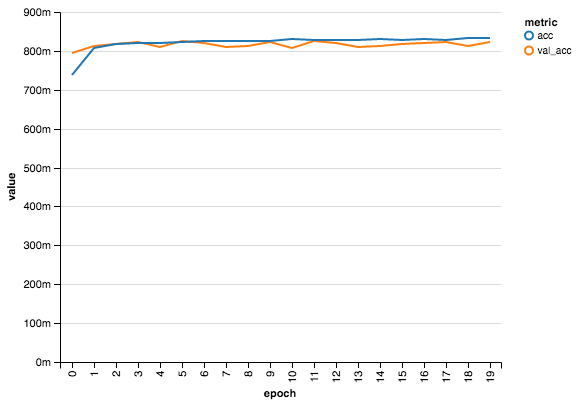

In [33]:
chart_acc(nn_fit_history)

In [34]:
score = nn_model.evaluate(mean_vec_test, y_test, verbose=1)
print 'Test score:', score[0]
print 'Test accuracy:', score[1]

2500/2500 [==============================] - 0s     
Test score: 0.371758093834
Test accuracy: 0.8372


---

# Model 3 (RNN)

In [35]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import Embedding, LSTM, GRU

In [58]:
word_index = {word: (index + 1) for index, word in enumerate(w2v_model.index2word)}

In [59]:
idx_vec_train = np.array([np.array([word_index[w] for w in mat]) for mat in word_vec_train])
idx_vec_valid = np.array([np.array([word_index[w] for w in mat]) for mat in word_vec_valid])
idx_vec_test = np.array([np.array([word_index[w] for w in mat]) for mat in word_vec_test])

In [60]:
max_train_len = max([x.shape[0] for x in idx_vec_train])
max_valid_len = max([x.shape[0] for x in idx_vec_valid])
max_test_len = max([x.shape[0] for x in idx_vec_test])

In [61]:
max_len = max([max_train_len, max_valid_len, max_test_len])

In [62]:
from keras.preprocessing.sequence import pad_sequences

pidx_vec_train = pad_sequences(idx_vec_train, maxlen=max_len)
pidx_vec_valid = pad_sequences(idx_vec_valid, maxlen=max_len)
pidx_vec_test = pad_sequences(idx_vec_test, maxlen=max_len)

In [63]:
w2v_weights = np.insert(w2v_model.syn0, 0, 0, axis=0)
w2v_dim = 100
nb_word = w2v_model.syn0.shape[0] + 1

In [64]:
rnn_model = Sequential([
        Embedding(nb_word, 
                  w2v_dim,
                  mask_zero=True,
                  weights=[w2v_weights], 
                  input_length=max_len),
        LSTM(w2v_dim),
        Dense(2, activation='softmax')])

rnn_model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
rnn_fit_history = rnn_model.fit(pidx_vec_train, y_train,
                    batch_size=128, nb_epoch=20, verbose=1,
                    validation_data=(pidx_vec_valid, y_valid))

Train on 20000 samples, validate on 2500 samples
Epoch 1/20
20000/20000 [==============================] - 1798s - loss: 0.4085 - acc: 0.8154 - val_loss: 0.2821 - val_acc: 0.8852
Epoch 2/20
  896/20000 [>.............................] - ETA: 1700s - loss: 0.2010 - acc: 0.9364